# N-Gram

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])

vocab = set(test_sentence)
word_to_ix = {word: i for i, word in enumerate(vocab)}


class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ix["beauty"]])

[(['forty', 'When'], 'winters'), (['winters', 'forty'], 'shall'), (['shall', 'winters'], 'besiege')]
[539.3035645484924, 407.73778676986694, 293.2746959924698, 181.42779803276062, 98.347058609128, 54.17402731627226, 33.70266044139862, 23.532789889723063, 17.82089263573289, 14.304765002802014]
tensor([-0.1246,  0.7189,  0.9462, -0.8164,  1.2619, -0.7507,  2.5560, -0.9022,
        -1.0665, -0.1257], grad_fn=<SelectBackward0>)


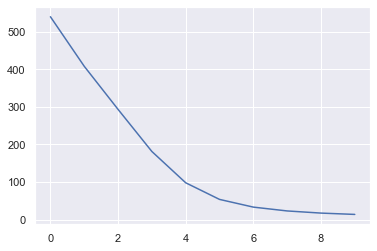

In [23]:
import seaborn as sns
sns.set()
_ = sns.lineplot(x=range(10), y=losses)

# CBOW

In [27]:
# CBOW pretraining

CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 10

raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

# to get index from word
word_to_ix = {word: i for i, word in enumerate(vocab)}

# to get index (vector) for context
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

data = []
# SLIDING WINDOW
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = (
        [raw_text[i - j - 1] for j in range(CONTEXT_SIZE)]
        + [raw_text[i + j + 1] for j in range(CONTEXT_SIZE)]
    )
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['are', 'We', 'to', 'study'], 'about'), (['about', 'are', 'study', 'the'], 'to'), (['to', 'about', 'the', 'idea'], 'study'), (['study', 'to', 'idea', 'of'], 'the'), (['the', 'study', 'of', 'a'], 'idea')]


In [28]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        """ Initialize a CBOW embedding network"""
        super(CBOW, self).__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
    
    def forward(self, inp):
        embeds = self.embeddings(inp).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


model = CBOW(vocab_size, EMBEDDING_DIM, CONTEXT_SIZE)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []

for epoch in range(10):
    total_loss = 0
    for context, word in data:
        context_idxs = make_context_vector(context, word_to_ix)
        model.zero_grad()
        log_probs = model(context_idxs)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[word]], dtype=torch.long))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    print(f"EPOCH {epoch} LOSS {total_loss}")

EPOCH 0 LOSS 229.29496836662292
EPOCH 1 LOSS 182.86609983444214
EPOCH 2 LOSS 141.75195944309235
EPOCH 3 LOSS 99.57786613702774
EPOCH 4 LOSS 62.10328894853592
EPOCH 5 LOSS 35.3193134367466
EPOCH 6 LOSS 20.17317482829094
EPOCH 7 LOSS 12.374255284667015
EPOCH 8 LOSS 8.25601577758789
EPOCH 9 LOSS 5.915358852595091


<AxesSubplot:>

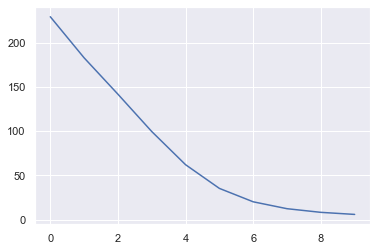

In [29]:
import seaborn as sns
sns.set()
sns.lineplot(x=range(10), y=losses)

In [30]:
print(model.embeddings.weight[word_to_ix["rules"]])

tensor([ 1.0598,  0.1472, -0.3301, -0.7565,  1.7621,  1.6223,  2.0284, -0.2342,
        -2.0062, -0.2386], grad_fn=<SelectBackward0>)


In [32]:
context_idxs = make_context_vector(context, word_to_ix)
print(context)
print(context_idxs)

['computer', 'the', 'our', 'spells.']
tensor([20,  8,  6, 17])


In [34]:
vocab_size = len(vocab)
embeddings = nn.Embedding(vocab_size, 10)
embeddings(context_idxs)

tensor([[ 0.0205,  0.2521, -0.9708, -1.6138,  0.2385,  0.1152, -0.0095, -0.1608,
         -0.1796,  0.1829],
        [-0.1885, -0.0128, -0.6668,  0.9433,  0.7933,  1.1324,  0.7662, -1.6539,
          0.9391,  1.0420],
        [-1.4610, -0.2474,  2.1972,  0.8515, -0.1622, -1.1795, -0.7174,  0.1843,
         -0.0064,  0.8089],
        [-0.0617, -1.6256,  0.4339, -0.4940,  0.5415,  0.8328,  0.1288, -0.2506,
          0.8303, -0.1647]], grad_fn=<EmbeddingBackward0>)

In [35]:
print(word)
word_to_ix[word]

with


37